In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
from tqdm import tqdm
%matplotlib inline

GPU acceleration enabled


In [2]:
ppy.gpu_utils.initialize_gpu(n=0)

using given n: 0
Starting SourceModule Code
Past the SourceModule code
CUDAC Available


In [20]:
def mu_to_mpc(mu):
    return np.power(10., 0.2*(mu-25.))

In [22]:
mu_to_mpc(25.)

1.0

In [3]:
plt.style.use('seaborn-poster')

In [4]:
f475w = ppy.instrument.ACS_WFC_F475W(exposure=375.)
f850lp = ppy.instrument.ACS_WFC_F850LP(exposure=560.)

In [14]:
f_m49 = ppy.instrument.default_m49_filters()
f_m49[0]._exposure, f_m49[1]._exposure

(560.0, 375.0)

In [10]:
f_m49

In [13]:
f_m31 = [f() for f in ppy.instrument.m31_filter_sets]
f_m31[0]._exposure, f_m31[1]._exposure

(1360.0, 3620.0)

In [9]:
f_m31

In [15]:
isoc_m49 = ppy.isochrones.Isochrone_Model(f_m49)
isoc_m31 = ppy.isochrones.Isochrone_Model(f_m31)

In [41]:
driv_m49 = ppy.driver.Driver(isoc_m49)
driv_m31 = ppy.driver.Driver(isoc_m31)

In [36]:
pcmd_m49 = np.loadtxt('../data/m49/pcmds/m49_t48_z-gz.pcmd', unpack=True)
pcmd_m31 = np.loadtxt('../data/m31_bulge_M2.dat', unpack=True)

# m31 data is in AB absolute mags
dmod_m49 = 31.3
dmod_m31 = 24.4
pcmd_m31[0] += dmod_m31

In [34]:
pcmd_m49, pcmd_m31

(array([[23.273386, 23.303814, 23.259745, ..., 23.235287, 23.219229,
         23.221729],
        [ 2.162174,  2.125359,  2.112757, ...,  2.251709,  2.196312,
          2.191738]]),
 array([[25.346939, 25.246066, 25.159676, ..., 25.082892, 25.172867,
         25.150114],
        [ 1.28262 ,  1.29257 ,  1.26145 , ...,  1.21849 ,  1.21187 ,
          1.22276 ]]))

In [125]:
gal_m49_var = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.2),
    ppy.dustmodels.SingleDust(),
    ppy.agemodels.TauModel(),
    ppy.distancemodels.VariableDistance()
)

In [49]:
sky_m49 = np.array([30.0, 27.6])

In [126]:
gal_m31 = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.2),
    ppy.dustmodels.SingleDust(),
    ppy.agemodels.TauModel(),
    ppy.distancemodels.FixedDistance(dmod_m31)
)
gal_m49 = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.2),
    ppy.dustmodels.SingleDust(),
    ppy.agemodels.TauModel(),
    ppy.distancemodels.FixedDistance(dmod_m49)
)

In [134]:
%%time
gal_m49.set_params(np.array([0.5, -1.5, 5.0, 1.]))
pcmd_sim_m49 = driv_m49.simulate(gal_m49, 512, downsample=5, shot_noise=True)[0]

CPU times: user 1.59 s, sys: 332 ms, total: 1.92 s
Wall time: 2.35 s


In [145]:
%%time
gal_m49_var.set_params(np.array([0.5, -1.5, 3.8, 1., 28.]))
pcmd_sim_m49_v = driv_m49.simulate(gal_m49_var, 512, downsample=5, shot_noise=True)[0]

CPU times: user 1.57 s, sys: 409 ms, total: 1.98 s
Wall time: 2.41 s


In [136]:
%%time
gal_m31.set_params(np.array([0.2, -.6, 2.6, 2.]))
pcmd_sim_m31 = driv_m31.simulate(gal_m31, 512, downsample=5, shot_noise=True, system='ab')[0]

CPU times: user 1.52 s, sys: 336 ms, total: 1.86 s
Wall time: 2.3 s


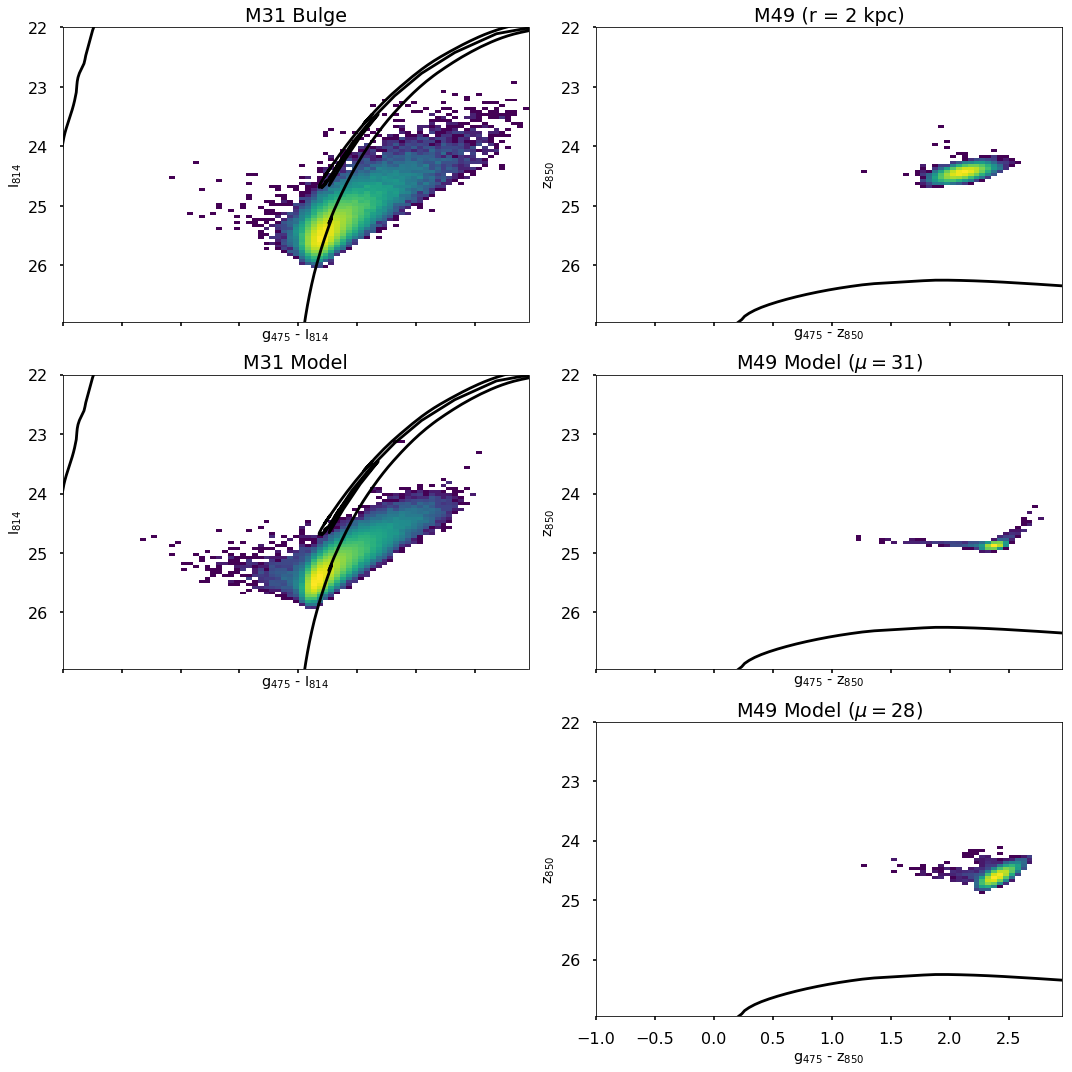

In [146]:
fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey='col', figsize=(15, 15))
bins = [np.arange(-1, 3, 0.05), np.arange(22, 27, 0.05)]

ax = axes[0,0]
ax.hist2d(pcmd_m31[1], pcmd_m31[0], bins=bins, norm=mpl.colors.LogNorm())
ax.set_title('M31 Bulge')

ax = axes[1,0]
ax.hist2d(pcmd_sim_m31[1], pcmd_sim_m31[0], bins=bins, norm=mpl.colors.LogNorm())
ax.set_title('M31 Model')

ax = axes[0,1]
ax.hist2d(pcmd_m49[1], pcmd_m49[0], bins=bins, norm=mpl.colors.LogNorm())
ax.set_title('M49 (r = 2 kpc)')

ax = axes[1,1]
ax.hist2d(pcmd_sim_m49[1], pcmd_sim_m49[0], bins=bins, norm=mpl.colors.LogNorm())
ax.set_title(r'M49 Model ($\mu = 31$)')

ax = axes[2,1]
ax.hist2d(pcmd_sim_m49_v[1], pcmd_sim_m49_v[0], bins=bins, norm=mpl.colors.LogNorm())
ax.set_title(r'M49 Model ($\mu = 28$)')

axes[2,0].axis('off')

for a in axes[:2,0]:
    ppy.plotting.plot_isochrone(isoc_m31, dmod=dmod_m31, axes=a, system='ab')
for a in axes[:,1]:
    ppy.plotting.plot_isochrone(isoc_m49, dmod=dmod_m49, axes=a)
    
plt.tight_layout()